## Описание задания

__Контекст__

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных. Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

__Описание данных__

Данные были взяты из каггл соревнования и представляют собой вопросы
и лекции в рамках Test of English for International Communication(TOEIC).
Тест английского языка для международного общения - это международный стандартизированный тест на знание английского языка для лиц, не
являющихся носителями языка. Он специально разработан для измерения
повседневных навыков владения английским языком людей, работающих в
международной среде. Существуют различные формы экзамена TOEIC, в нашем случае это TOEIC Listening Reading, который состоит из двух одинаково градуированных тестов оценки понимания деятельности на общую сумму
возможных 990 баллов. В датасете 100 миллионов взаимодействий студента с
вопросами или лекциями. Данные взаимодействия описаны тремя таблицами:

`TRAIN.CSV:`

Это основная таблица, которая связывает студента с вопросом или лекцией, с которыми он взаимодействует, а также дополнительная информация
об этом взаимодействии. Список колонок и краткое их описание:

* row_id: (int64) порядковый номер строки в этой таблице.
* timestamp: (int64) время в миллисекундах между текущим взаимодействием и первым событием связанным с данным ученика.
* user_id: (int32) идентификационный код ученика.
* content_id: (int16) идентификационный код вопроса или лекции.
* content_type_id: (int8) 0 если это вопрос, 1 если лекция.
* task_container_id: (int16) идентификационный код группы вопросов, в которой задан текущий вопрос.
* user_answer: (int8) вариант ответа, который выбрал ученик. Всего вариантов может быть 4. В случае если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* answered_correctly: (int8) правильно ли ученик ответил на вопрос. В случае, если взаимодействие - это лекция, а не вопрос, то данное поле равно -1.
* prior_question_elapsed_time: (float32) среднее время в миллисекундах, которое ученику потребовалось, чтобы ответить на все вопросы в предыдущей группе, игнорируя любые лекции между ними. Равен 0 для первой группы вопросов, заданной ученику.
* prior_question_had_explanation: (bool) смотрел ли ученик объяснение и правильный ответ на предыдущий вопрос.

`QUESTIONS.CSV:`

Таблица описывающая вопрос. Количество вопросов в отличии от количества учеников заранее зафиксировано, также задания повторно предлагаются
различным ученикам. Список колонок:

* question_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* bundle_id: код по которому вопросы объединяются в группы.
* correct_answer: правильный ответ на вопрос.
* part: один из семи типов вопросов TOEIC. Ниже будет краткое описание каждого
* tags: один или несколько кодов с тэгами для данного вопроса. Описание тэгов не представлено, но самих кодов достаточно для того, чтобы
сделать кластеризацию.

`LECTURES.CSV`

Данная таблица аналогична таблице про вопросы, но она про лекции,
перейдем к ее описанию:

* lecture_id: внешний ключ(foreign key) для связывание данной информации с таблицей train.
* type_of: краткое описание основной цели лекции.
* part: один из семи типов, который был в таблице с вопросами.
* tag: один тэг в качестве числа, который представляет лекцию, его значение не дано, также как и в вопросах.

__План выполнения задания__

* Первичный обзор данных

* Предобработка данных

* Выявление характеристик , влияющих на успеваемость студентов



## Первичный обзор данных

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from matplotlib import pyplot as plt
import seaborn as sns

train = pd.read_csv('data/train.csv')
questions = pd.read_csv('data/questions.csv')
lectures = pd.read_csv('data/lectures.csv')


In [2]:
def info_check(df):
    display(df.info())
    display(df.describe().T)
    display(df.describe(include = 'object').T)
    duplicates = df.duplicated().sum()
    nas = df.isna().sum()
    print('Всего дубликатов в файле:',duplicates,'\n')
    print('Всего пропусков в файле:','\n'*2,nas,'\n')
    

__Файл TRAIN__

In [3]:
info_check(train)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 10 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1048575 non-null  int64  
 1   timestamp                       1048575 non-null  int64  
 2   user_id                         1048575 non-null  int64  
 3   content_id                      1048575 non-null  int64  
 4   content_type_id                 1048575 non-null  int64  
 5   task_container_id               1048575 non-null  int64  
 6   user_answer                     1048575 non-null  int64  
 7   answered_correctly              1048575 non-null  int64  
 8   prior_question_elapsed_time     1023681 non-null  float64
 9   prior_question_had_explanation  1044590 non-null  object 
dtypes: float64(1), int64(8), object(1)
memory usage: 80.0+ MB


None

,count,mean,std,min,25%,50%,75%,max
row_id,1048575.0,5.242870e+05,3.026977e+05,0.0,262143.5,5.242870e+05,7.864305e+05,1.048574e+06
timestamp,1048575.0,7.468135e+09,1.073095e+10,0.0,523354679.5,2.857688e+09,1.028630e+10,7.809200e+10
user_id,1048575.0,1.069181e+07,6.342013e+06,115.0,4980312.0,1.038811e+07,1.596357e+07,2.188989e+07
content_id,1048575.0,5.231905e+03,3.889087e+03,0.0,2042.0,5.045000e+03,7.431000e+03,3.273600e+04
content_type_id,1048575.0,1.994040e-02,1.397955e-01,0.0,0.0,0.000000e+00,0.000000e+00,1.000000e+00
task_container_id,1048575.0,8.052636e+02,1.021281e+03,0.0,109.0,3.910000e+02,1.113000e+03,7.739000e+03
user_answer,1048575.0,1.374361e+00,1.194519e+00,-1.0,0.0,1.000000e+00,3.000000e+00,3.000000e+00
answered_correctly,1048575.0,6.177565e-01,5.253708e-01,-1.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00
prior_question_elapsed_time,1023681.0,2.540369e+04,1.982137e+04,0.0,16000.0,2.100000e+04,3.000000e+04,3.000000e+05


,count,unique,top,freq
prior_question_had_explanation,1044590,2,True,933000


Всего дубликатов в файле: 0 

Всего пропусков в файле: 

 row_id                                0
timestamp                             0
user_id                               0
content_id                            0
content_type_id                       0
task_container_id                     0
user_answer                           0
answered_correctly                    0
prior_question_elapsed_time       24894
prior_question_had_explanation     3985
dtype: int64 



__Файл QUESTIONS__

In [4]:
info_check(questions)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB


None

,count,mean,std,min,25%,50%,75%,max
question_id,13523.0,6761.000000,3903.898180,0.0,3380.5,6761.0,10141.5,13522.0
bundle_id,13523.0,6760.510907,3903.857783,0.0,3379.5,6761.0,10140.0,13522.0
correct_answer,13523.0,1.455298,1.149707,0.0,0.0,1.0,3.0,3.0
part,13523.0,4.264956,1.652553,1.0,3.0,5.0,5.0,7.0


,count,unique,top,freq
tags,13522,1519,8,738


Всего дубликатов в файле: 0 

Всего пропусков в файле: 

 question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64 



__Файл Lectures__

In [5]:
info_check(lectures)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB


None

,count,mean,std,min,25%,50%,75%,max
lecture_id,418.0,16983.401914,9426.164660,89.0,9026.25,17161.5,24906.25,32736.0
tag,418.0,94.480861,53.586487,0.0,50.25,94.5,140.00,187.0
part,418.0,4.267943,1.872424,1.0,2.00,5.0,6.00,7.0


,count,unique,top,freq
type_of,418,4,concept,222


Всего дубликатов в файле: 0 

Всего пропусков в файле: 

 lecture_id    0
tag           0
part          0
type_of       0
dtype: int64 



__Выводы__

В рассматриваемых данных:
* отсутсвуют полные дубликаты
* в файле Train есть пропуски в столбцах prior_question_elapsed_time, prior_question_had_explanation
* в столбце questions['tags'] также есть один пропуск
* столбцу lectures['type_of'] можно задать тип category
* в файле questions столбец tags имеет тип данных object, хотя представлены данные числовыми кодами
* в файле train в столбце 'prior_question_had_explanation' имеют тип object, хотя значения булевы
* столбцам train['timestamp'] и train['prior_question_elapsed_time'] можно задать тип timedelta

## Предобработка данных

__Обработка пропусков__

In [6]:
# проверим долю пропусков в столбце 'prior_question_had_explanation' 
print('доля пропусков в столбце "prior_question_had_explanation" ',
    round(train['prior_question_had_explanation'].isna().sum()
    /train['prior_question_had_explanation'].shape[0]
    *100,3),'%'
)
display(train['prior_question_had_explanation'].value_counts(normalize = True))

# в 90% случаев у нас занчение True
# заменим пол процента пропусков значением True
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].fillna(True)


доля пропусков в столбце "prior_question_had_explanation"  0.38 %


True     0.893173
False    0.106827
Name: prior_question_had_explanation, dtype: float64

In [7]:
# проверим долю пропусков в столбце 'prior_question_elapsed_time' 
print('доля пропусков в столбце "prior_question_elapsed_time" ',
    round(train['prior_question_elapsed_time'].isna().sum()
    /train['prior_question_elapsed_time'].shape[0]
    *100,3),'%'
)

# согласно условиям в данном столбце 0 соответсвует первой группе вопросов, заданной ученику.
# проверим  есть ли нули вообще

if train['prior_question_elapsed_time'].min() == 0:
    print("В столбце нули есть")
else:
    print("В столбце нулей нет")

доля пропусков в столбце "prior_question_elapsed_time"  2.374 %
В столбце нули есть


In [8]:
print(
    'Всего пропусков в столбце "prior_question_elapsed_time" :',
    train['prior_question_elapsed_time'].isna().sum()
)

Всего пропусков в столбце "prior_question_elapsed_time" : 24894


In [9]:
print(
    "Пропуски вызываны лекциями",
    train.query('content_type_id == 1')['prior_question_elapsed_time'].isna().sum()
)

Пропуски вызываны лекциями 20909


In [10]:
print(
    "Пропуски вызываны тем, что вопрос первый",
    train.query('content_type_id == 0 & content_type_id==0')['prior_question_elapsed_time'].isna().sum()
)

Пропуски вызываны тем, что вопрос первый 3985


In [11]:
train["prior_question_elapsed_time"] = train["prior_question_elapsed_time"].fillna(0)

In [12]:
# проверим опять долю пропусков в столбце 'prior_question_elapsed_time' 
print('доля пропусков в столбце "prior_question_elapsed_time" теперь составляет ',
    round(train['prior_question_elapsed_time'].isna().sum()
    /train['prior_question_elapsed_time'].shape[0]
    *100,3),'%'
)

доля пропусков в столбце "prior_question_elapsed_time" теперь составляет  0.0 %


In [13]:
# проверим долю пропусков в столбце questions['tags']
print(
    round(questions['tags'].isna().sum()
    /questions['tags'].shape[0]
    *100,6),'%'
)

# всего 0.007395 процента от общего объема
# удалим данную часть данных
questions = questions.dropna(subset = 'tags')

0.007395 %


__Выводы__

* в столбце questions['tags'] было 0.007395 % пропусков, такими значениями можно пренебречь и удалить
* выяснили что в столбце train['prior_question_had_explanation'] в 90 % случаев стоит значение True , поэтому заменили пропуски ( которых было всего 0.38 % от общего количества значений) на True, и изменили тип данных столбца на bool
*  в столбце train['prior_question_elapsed_time'] изначально было 2.374 % пропусков
    * мы посмотрели с каким из столбцов данные пропуски коррелируют, на 15% пропуски коррелировали со значениями из столбца 'task_container_id'
    * затем мы выяснили что  в 15% случаев в столбце 'task_container_id' стояли значения 0 - то есть первая группа вопросов
    * согласно условиям задачи первой группе вопросов (т.е. нулевой) prior_question_elapsed_time равен 0 
    * заменили пропуски на 0 для первой группы вопросов
    * доля пропусков в столбце "prior_question_elapsed_time" теперь составляет  1.996 %
    * удалили строки с данными пропусками

__Изменение типов данных__

In [14]:
# изменим тип данных в столбце questions['tags']

questions['tags'] = questions['tags'].apply(lambda x: int(x.replace(' ','')))

# изменим тип данных в столбце 'prior_question_had_explanation'
train['prior_question_had_explanation'] = train['prior_question_had_explanation'].astype('bool')

In [15]:
# изменим тип данных для временных интервалов с числового на timedelta

train['timestamp'] = train['timestamp'].apply(lambda x: timedelta(milliseconds = x))

train['prior_question_elapsed_time'] = (
    train['prior_question_elapsed_time'].apply(lambda x: timedelta(milliseconds = x))
)

In [16]:
# изменим тип данных для столбца lectures['type_of'] на category
lectures['type_of'] = lectures['type_of'].astype('category')

__Удаление ненужных признаков__

In [17]:
# удаление признака bundle_id из QUESTIONS
questions = questions.drop(['bundle_id','correct_answer'],axis = 1)


## Выявление характеристик , влияющих на успеваемость студентов

* количество уникальных студентов, участвующих в тестировании

* распределение сеансов работы с вопросами по дням
* сколько уникальных вопросов приходится на каждую группу вопросов
* влияет ли просмотр лекций на количество правильных вопросов?
* какая группа вопросов занимает больше всего времени на ответ


In [18]:
# количество уникальных студентов, участвующих в тестировании

user_qty = train['user_id'].nunique()
user_qty 

3995

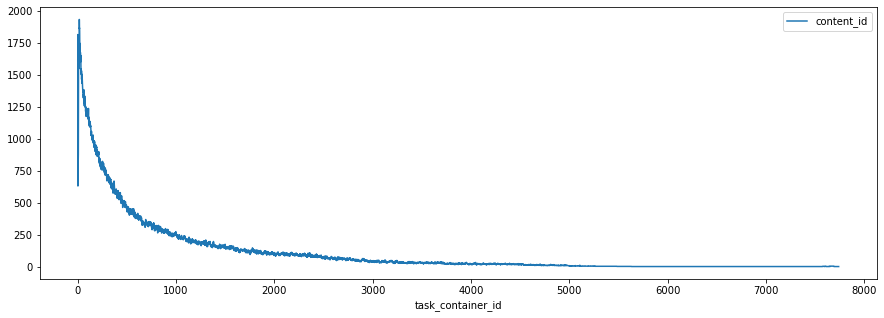

In [19]:
# сколько уникальных вопросов приходится на каждую группу вопросов

fig_1 = (
    train[train['content_type_id']==0]
    .groupby('task_container_id')['content_id']
    .agg('nunique').reset_index()
    .plot(
        x='task_container_id',y='content_id',
        figsize=(15,5)
    )
)
plt.show()

In [20]:
train['day']=train['timestamp'].dt.days

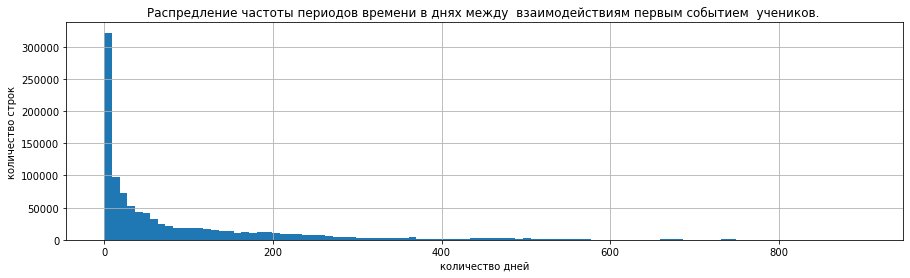

In [21]:
plt.figure(figsize = (15,4))
plt.xlabel('количество дней')
plt.ylabel('количество строк')
plt.title('Распредление частоты периодов времени в днях между  взаимодействиям первым событием  учеников. ')
train['day'].hist(bins = 100);

__Влияние просмотра лекций на успеваемость__

In [22]:
# влияет ли просмотр лекций на количество правильных ответов?

users_performance = (
    train.query('content_type_id == 0')
    .groupby('user_id',as_index = False).agg({
        'answered_correctly':['sum','count'],
    })
)
users_performance.columns = users_performance.columns.droplevel(1)
users_performance.columns = ['user_id','correct_answers_qty','overall_answers_qty']

user_lectures = (
    train.query('content_type_id == 1')
    .groupby('user_id',as_index = False).agg({
        'answered_correctly':'count'
    })
)
user_lectures.columns = ['user_id','lectures_qty']

users_performance = users_performance.merge(user_lectures, on = 'user_id')
users_performance['success_rate__%'] = (
    (users_performance['correct_answers_qty']
    /users_performance['overall_answers_qty']*100).round()
)

users_performance['lectures_per_question_%'] = (
    ((users_performance['lectures_qty']
    /(users_performance['overall_answers_qty']+users_performance['lectures_qty']))*100).round()
)
users_performance.head() 

,user_id,correct_answers_qty,overall_answers_qty,lectures_qty,success_rate__%,lectures_per_question_%
0,2746,11,19,1,58.0,5.0
1,5382,84,125,3,67.0,2.0
2,8623,70,109,3,64.0,3.0
3,12741,152,265,6,57.0,2.0
4,13134,878,1243,7,71.0,1.0


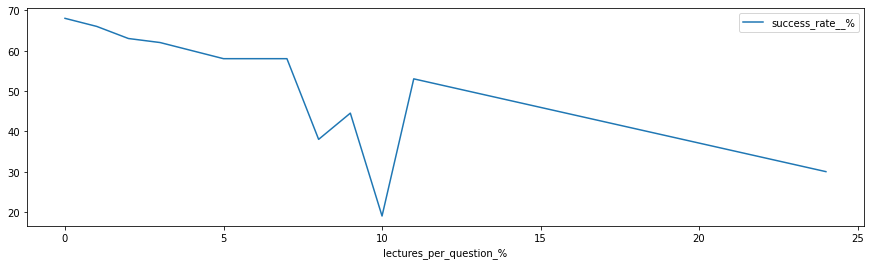

In [23]:
(
    users_performance.groupby('lectures_per_question_%',as_index = False)
    .agg({'success_rate__%':'median'}).plot(
        x = 'lectures_per_question_%',y = 'success_rate__%',
        figsize = (15,4)
    )
);

In [24]:
users_performance.groupby('lectures_per_question_%',as_index = False).agg({'success_rate__%':'median'})

,lectures_per_question_%,success_rate__%
0,0.0,68.0
1,1.0,66.0
2,2.0,63.0
3,3.0,62.0
4,4.0,60.0
5,5.0,58.0
6,6.0,58.0
7,7.0,58.0
8,8.0,38.0
9,9.0,44.5


__Вывод__

Это странно, но мы видим тенденцию, что чем больше доля лекций в общем колчичестве взаимодействий, то тем ниже медианная доля правильных ответов.

__Влияние группы вопросов на уровень положительных оценок__

In [25]:
train.head()

,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,day
0,0,0 days 00:00:00,115,5692,0,1,3,1,0 days 00:00:00,True,0
1,1,0 days 00:00:56.943000,115,5716,0,2,2,1,0 days 00:00:37,False,0
2,2,0 days 00:01:58.363000,115,128,0,0,0,1,0 days 00:00:55,False,0
3,3,0 days 00:02:11.167000,115,7860,0,3,0,1,0 days 00:00:19,False,0
4,4,0 days 00:02:17.965000,115,7922,0,4,1,1,0 days 00:00:11,False,0


In [26]:
questions = questions.rename(columns = {'question_id':'task_container_id'})

In [27]:
train = train.merge(questions.iloc[:,[0,1]], on = 'task_container_id',how='left')

In [28]:
answ_group_impact  = (
    train[train['content_type_id']==0]
    .groupby('part',as_index = False).agg({'answered_correctly':['sum','count']})
)

answ_group_impact.columns = answ_group_impact.columns.droplevel(1)
answ_group_impact.columns = ['answ_group_number','correct_answers_qty','overall_answers_qty']
answ_group_impact['success_rate__%'] = (
    (answ_group_impact['correct_answers_qty']
    /answ_group_impact['overall_answers_qty']*100).round()
)
answ_group_impact

,answ_group_number,correct_answers_qty,overall_answers_qty,success_rate__%
0,1,218522,359823,61.0
1,2,311915,464359,67.0
2,3,86981,127416,68.0
3,4,30088,43855,69.0
4,5,20753,30814,67.0
5,6,89,407,22.0
6,7,325,992,33.0


__Выводы__

Можем увидеть, что процент правильных ответов в группах с первой по пятую приблизительно одинаковый. Но в 6 и 7 ой группах уровень правильных значительно падает. Скорее всего это группы вопросов с повышенной сложностью.